## **Data and code setup**

In [0]:
%%capture
!pip install gdown
!pip3 install gpustat

In [0]:
%%capture
!git clone https://github.com/gevero/enet_tensorflow.git

In [0]:
%%capture
!gdown https://drive.google.com/uc?id=1gt0nCGft0winZqHBYaTb1EL6zM8lrKPA
!unzip camvid.zip

## **Notebook Setup**

In [1]:
# update to tf 2.0
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.1
except Exception:
  pass

# importing standard libraries
import tensorflow as tf
print(tf.__version__)
import matplotlib.pylab as plt
import numpy as np
import os, os.path
from functools import partial
from google.colab import files

# Importing utils and models
import sys
sys.path.append('./enet_tensorflow')
from utils import preprocess_img_label, map_singlehead, map_doublehead, map_label, tf_dataset_generator, get_class_weights
from models import EnetModel

2.1.0-rc2


## **Create training test and validation dataset, and get class weights**

In [2]:
%%capture
# creating datasets
img_pattern = "./datasets/train/images/*.png"
label_pattern = "./dataset/train/labels/*.png"
img_pattern_val = "./dataset/val/images/*.png"
label_pattern_val = "./dataset/val/labels/*.png"
img_pattern_test = "./dataset/test/images/*.png"
label_pattern_test = "./dataset/test/labels/*.png"

# batch size
batch_size = 8

# image size
img_height = 360
img_width = 480
h_enc = img_height // 8
w_enc = img_width // 8
h_dec = img_height
w_dec = img_width

# create (img,label) string tensor lists
filelist_train = preprocess_img_label(img_pattern, label_pattern)
filelist_val = preprocess_img_label(img_pattern_val, label_pattern_val)
filelist_test = preprocess_img_label(img_pattern_test, label_pattern_test)

# training dataset size
n_train = tf.data.experimental.cardinality(filelist_train).numpy()
n_val = tf.data.experimental.cardinality(filelist_val).numpy()
n_test = tf.data.experimental.cardinality(filelist_test).numpy()

# define mapping functions for single and double head nets
map_single = lambda img_file, label_file: map_singlehead(
    img_file, label_file, h_dec, w_dec)
map_double = lambda img_file, label_file: map_doublehead(
    img_file, label_file, h_enc, w_enc, h_dec, w_dec)

# create single head datasets
train_single_ds = filelist_train.shuffle(n_train).map(map_single).cache().batch(batch_size).repeat()
val_single_ds = filelist_val.map(map_single).cache().batch(batch_size).repeat()
test_single_ds = filelist_test.map(map_single).cache().batch(batch_size).repeat()

# create double head datasets
train_double_ds = filelist_train.shuffle(n_train).map(map_double).cache().batch(batch_size).repeat()
val_double_ds = filelist_val.map(map_double).cache().batch(batch_size).repeat()
test_double_ds = filelist_test.map(map_double).cache().batch(batch_size).repeat()

# get class weights
label_filelist = tf.data.Dataset.list_files(label_pattern, shuffle=False)
label_ds = label_filelist.map(lambda x: map_label(x, h_dec, w_dec))
class_weights = get_class_weights(label_ds).tolist()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'defaults'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'defaults'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'defaults'


## **Example (Image,Label) pair from the validation set**

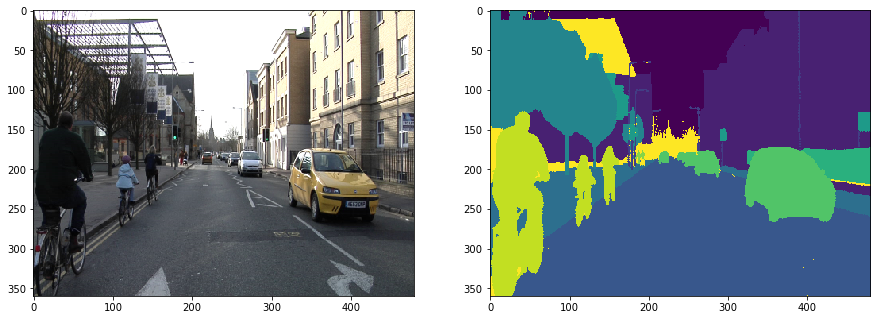

In [4]:
for img,iml in train_single_ds.take(1):
  plt.figure(figsize=(15,10))
  plt.subplot(1,2,1)
  plt.imshow(img.numpy()[0,:,:,:])
  plt.subplot(1,2,2)
  plt.imshow(iml.numpy()[0,:,:,0])

## **1 - Two stage training: first Encoder then Decoder**

### Training the encoder

In [5]:
Enet = EnetModel(C=12,MultiObjective=True,l2=1e-3)

In [6]:
for layer in Enet.layers[-6:]:
  layer.trainable = False

In [7]:
# compile model: only the first objective matters
n_epochs = 100
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
Enet.compile(optimizer=adam_optimizer,
             loss=['sparse_categorical_crossentropy','sparse_categorical_crossentropy'],
             metrics=['accuracy','accuracy'],
             loss_weights=[1.0,0.0])

In [10]:
enet_enc_history = Enet.fit(x= train_double_ds,
        epochs=n_epochs,
        steps_per_epoch=n_train//batch_size,
        validation_data= val_double_ds,
        validation_steps=n_val//batch_size//5,
        class_weight=[class_weights,class_weights])

Train for 45 steps, validate for 2 steps
Epoch 1/100
10/45 [=====>........................] - ETA: 3:47 - loss: 7.3625 - output_1_loss: 4.0620 - output_2_loss: 2.7764 - output_1_accuracy: 0.3781 - output_2_accuracy: 0.0524

### Training the decoder

In [0]:
for layer in Enet.layers[-6:]:
  layer.trainable = True
for layer in Enet.layers[:-6]:
  layer.trainable = False

In [0]:
# compile model: only the first objective matters
n_epochs = 100
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
Enet.compile(optimizer=adam_optimizer,
             loss=['sparse_categorical_crossentropy','sparse_categorical_crossentropy'],
             metrics=['accuracy','accuracy'],
             loss_weights=[0.0,1.0])

In [13]:
enet_dec_history = Enet.fit(x= train_double_ds,
        epochs=n_epochs,
        steps_per_epoch=n_train//batch_size,
        validation_data= val_double_ds,
        validation_steps=n_val//batch_size//5,
        class_weight=[class_weights,class_weights])

Train for 36 steps, validate for 2 steps
Epoch 1/100
36/36 [==============================] - 21s 588ms/step - loss: 3.0345 - output_1_loss: 0.2107 - output_2_loss: 2.4033 - output_1_accuracy: 0.9274 - output_2_accuracy: 0.1735 - val_loss: 2.8497 - val_output_1_loss: 0.4904 - val_output_2_loss: 2.2352 - val_output_1_accuracy: 0.8801 - val_output_2_accuracy: 0.2847
Epoch 2/100
36/36 [==============================] - 5s 144ms/step - loss: 2.3436 - output_1_loss: 0.2134 - output_2_loss: 1.7438 - output_1_accuracy: 0.9262 - output_2_accuracy: 0.4565 - val_loss: 2.4181 - val_output_1_loss: 0.5073 - val_output_2_loss: 1.8336 - val_output_1_accuracy: 0.8748 - val_output_2_accuracy: 0.4825
Epoch 3/100
36/36 [==============================] - 5s 143ms/step - loss: 1.9046 - output_1_loss: 0.2130 - output_2_loss: 1.3351 - output_1_accuracy: 0.9263 - output_2_accuracy: 0.5992 - val_loss: 2.1805 - val_output_1_loss: 0.4807 - val_output_2_loss: 1.6268 - val_output_1_accuracy: 0.8787 - val_output_2_

### Check performance

In [14]:
Enet.evaluate(x=test_double_ds,steps=n_test//batch_size)

23/23 [==============================] - 3s 119ms/step - loss: 1.1771 - output_1_loss: 0.9747 - output_2_loss: 0.9132 - output_1_accuracy: 0.7895 - output_2_accuracy: 0.7962


[1.1771282139031782, 0.97469443, 0.9131965, 0.78949434, 0.7962253]

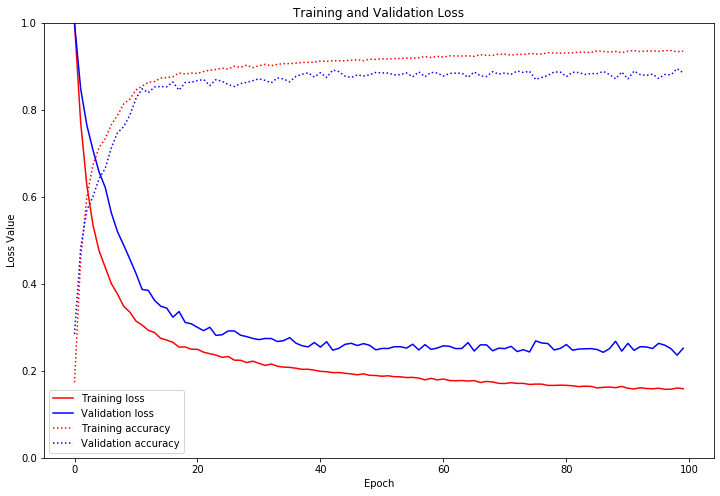

In [15]:
loss = enet_dec_history.history['loss']
val_loss = enet_dec_history.history['val_loss']
acc = enet_dec_history.history['output_2_accuracy']
val_acc = enet_dec_history.history['val_output_2_accuracy']

epochs = range(n_epochs)

plt.figure(figsize=(12,8))
plt.plot(epochs, loss/np.max(loss), 'r', label='Training loss')
plt.plot(epochs, val_loss/np.max(val_loss), 'b', label='Validation loss')
plt.plot(epochs, acc, 'r:', label='Training accuracy')
plt.plot(epochs, val_acc, 'b:', label='Validation accuracy')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## **2 - Training both objectives simultaneously**

###Training

In [0]:
EnetMulti = EnetModel(C=12,MultiObjective=True,l2=1e-3)

In [0]:
# compile model: only the first objective matters
n_epochs = 75
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
EnetMulti.compile(optimizer=adam_optimizer,
             loss=['sparse_categorical_crossentropy','sparse_categorical_crossentropy'],
             metrics=['accuracy','accuracy'],
             loss_weights=[0.5,0.5])

In [18]:
enet_multi_history = EnetMulti.fit(x= train_double_ds,
        epochs=n_epochs,
        steps_per_epoch=n_train//batch_size,
        validation_data= val_double_ds,
        validation_steps=n_val//batch_size//5,
        class_weight=[class_weights,class_weights])

Train for 36 steps, validate for 2 steps
Epoch 1/75
36/36 [==============================] - 35s 968ms/step - loss: 5.8270 - output_1_loss: 2.6799 - output_2_loss: 2.5121 - output_1_accuracy: 0.5579 - output_2_accuracy: 0.1473 - val_loss: 5.3332 - val_output_1_loss: 1.9114 - val_output_2_loss: 2.4475 - val_output_1_accuracy: 0.3958 - val_output_2_accuracy: 0.2406
Epoch 2/75
36/36 [==============================] - 9s 237ms/step - loss: 4.6798 - output_1_loss: 1.1838 - output_2_loss: 2.0243 - output_1_accuracy: 0.6861 - output_2_accuracy: 0.3644 - val_loss: 5.0112 - val_output_1_loss: 1.7073 - val_output_2_loss: 2.3288 - val_output_1_accuracy: 0.4038 - val_output_2_accuracy: 0.2840
Epoch 3/75
36/36 [==============================] - 9s 237ms/step - loss: 4.1545 - output_1_loss: 0.9222 - output_2_loss: 1.5587 - output_1_accuracy: 0.7275 - output_2_accuracy: 0.5603 - val_loss: 4.7032 - val_output_1_loss: 1.5661 - val_output_2_loss: 2.1789 - val_output_1_accuracy: 0.5157 - val_output_2_acc

### Check performance

In [19]:
EnetMulti.evaluate(x=test_double_ds,steps=n_test//batch_size)

23/23 [==============================] - 2s 83ms/step - loss: 0.9806 - output_1_loss: 0.7862 - output_2_loss: 0.7352 - output_1_accuracy: 0.8073 - output_2_accuracy: 0.8102


[0.9805656749269237, 0.7862072, 0.7351572, 0.8073446, 0.81017834]

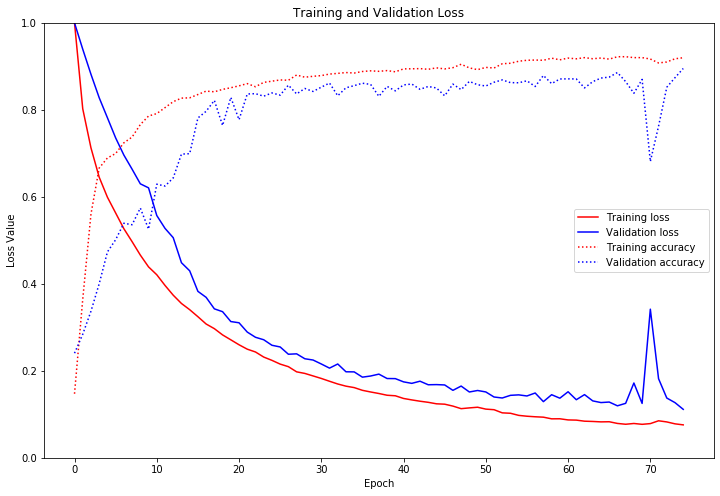

In [20]:
loss = enet_multi_history.history['loss']
val_loss = enet_multi_history.history['val_loss']
acc = enet_multi_history.history['output_2_accuracy']
val_acc = enet_multi_history.history['val_output_2_accuracy']

epochs = range(n_epochs)

plt.figure(figsize=(12,8))
plt.plot(epochs, loss/np.max(loss), 'r', label='Training loss')
plt.plot(epochs, val_loss/np.max(val_loss), 'b', label='Validation loss')
plt.plot(epochs, acc, 'r:', label='Training accuracy')
plt.plot(epochs, val_acc, 'b:', label='Validation accuracy')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## **3 - EndtoEnd Training**

In [0]:
EnetEndToEnd = EnetModel(C=12,MultiObjective=False,l2=1e-3)

In [0]:
# compile model: only the first objective matters
n_epochs = 100
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
EnetEndToEnd.compile(optimizer=adam_optimizer,
             loss=['sparse_categorical_crossentropy'],
             metrics=['accuracy'])

In [23]:
enet_endtoend_history = EnetEndToEnd.fit(x= train_single_ds,
        epochs=n_epochs,
        steps_per_epoch=n_train//batch_size,
        validation_data= val_single_ds,
        validation_steps=n_val//batch_size//5,
        class_weight=class_weights)

Train for 36 steps, validate for 2 steps
Epoch 1/100
36/36 [==============================] - 34s 931ms/step - loss: 5.3164 - accuracy: 0.2087 - val_loss: 5.1214 - val_accuracy: 0.2364
Epoch 2/100
36/36 [==============================] - 9s 238ms/step - loss: 4.3172 - accuracy: 0.3679 - val_loss: 4.5080 - val_accuracy: 0.2881
Epoch 3/100
36/36 [==============================] - 9s 237ms/step - loss: 3.5398 - accuracy: 0.5263 - val_loss: 4.0404 - val_accuracy: 0.3402
Epoch 4/100
36/36 [==============================] - 8s 236ms/step - loss: 2.9823 - accuracy: 0.6439 - val_loss: 3.6995 - val_accuracy: 0.3504
Epoch 5/100
36/36 [==============================] - 9s 237ms/step - loss: 2.5790 - accuracy: 0.6827 - val_loss: 3.3728 - val_accuracy: 0.3810
Epoch 6/100
36/36 [==============================] - 9s 238ms/step - loss: 2.2949 - accuracy: 0.6930 - val_loss: 3.1465 - val_accuracy: 0.4073
Epoch 7/100
36/36 [==============================] - 9s 238ms/step - loss: 2.0475 - accuracy: 0.7182

### Check performance

In [24]:
EnetEndToEnd.evaluate(x=test_single_ds,steps=n_test//batch_size)

23/23 [==============================] - 3s 122ms/step - loss: 1.1029 - accuracy: 0.7773


[1.102916621643564, 0.7772922]

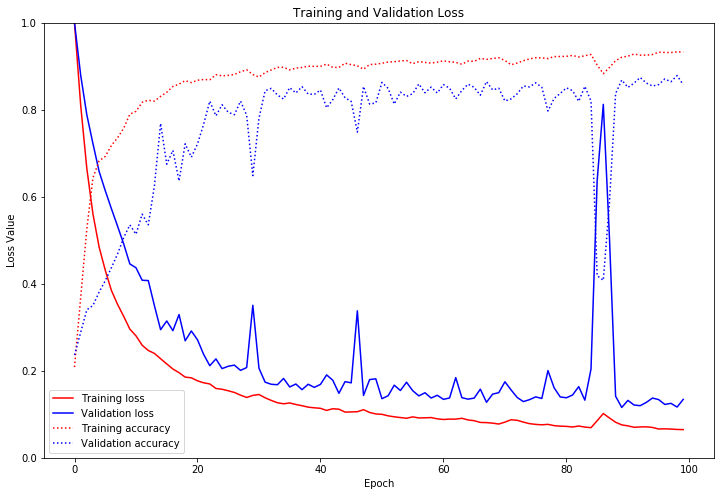

In [25]:
loss = enet_endtoend_history.history['loss']
val_loss = enet_endtoend_history.history['val_loss']
acc = enet_endtoend_history.history['accuracy']
val_acc = enet_endtoend_history.history['val_accuracy']

epochs = range(n_epochs)

plt.figure(figsize=(12,8))
plt.plot(epochs, loss/np.max(loss), 'r', label='Training loss')
plt.plot(epochs, val_loss/np.max(val_loss), 'b', label='Validation loss')
plt.plot(epochs, acc, 'r:', label='Training accuracy')
plt.plot(epochs, val_acc, 'b:', label='Validation accuracy')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## **Test Masks**

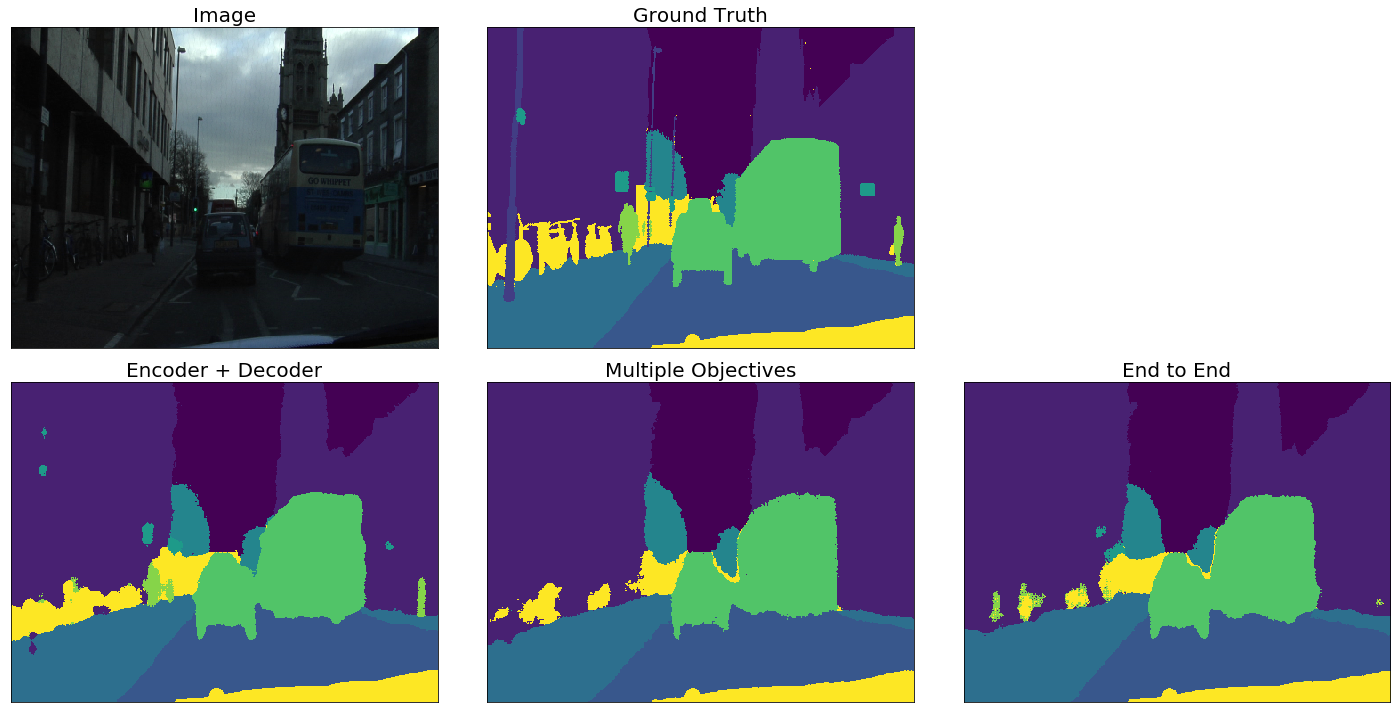

In [64]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]
for img,iml in train_dec_ds.take(10):
  img_test = img
  iml_test = iml

img_enc_probs, img_dec_probs = Enet(img_test[0:1,:,:,:])
img_enc_probs, img_multi_probs = EnetMulti(img_test[0:1,:,:,:])
img_endtoend_probs = EnetEndToEnd(img_test[0:1,:,:,:])
img_dec_out = create_mask(img_dec_probs)
img_multi_out = create_mask(img_multi_probs)
img_endtoend_out = create_mask(img_endtoend_probs)

plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.xticks([])
plt.yticks([])
plt.title('Image',fontdict={'fontsize':20})
plt.imshow(img_test.numpy()[0,:,:,:])

plt.subplot(2,3,2)
plt.xticks([])
plt.yticks([])
plt.title('Ground Truth',fontdict={'fontsize':20})
plt.imshow(iml_test.numpy()[0,:,:,0])

plt.subplot(2,3,4)
plt.imshow(img_dec_out[:,:,0])
plt.xticks([])
plt.yticks([])
plt.title('Encoder + Decoder',fontdict={'fontsize':20})

plt.subplot(2,3,5)
plt.xticks([])
plt.yticks([])
plt.title('Multiple Objectives',fontdict={'fontsize':20})
plt.imshow(img_multi_out[:,:,0])

plt.subplot(2,3,6)
plt.xticks([])
plt.yticks([])
plt.title('End to End',fontdict={'fontsize':20})
plt.imshow(img_endtoend_out[:,:,0])

plt.tight_layout()
plt.savefig('./segmentation.png')

# **Save models**
You can download them in your google drive. Mount it with che command below and drag and drop the weight files

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
Enet.save_weights('Enet.tf')
EnetMulti.save_weights('EnetMulti.tf')
EnetEndToEnd.save_weights('EnetEndToEnd.tf')